In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Airline Delays Analysis").getOrCreate()

In [ ]:
df= spark.read.csv('/content/drive/MyDrive/BI_Assignment/combined_output.csv', header=True, inferSchema=True)

In [ ]:
df.show(5)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

In [ ]:
# Step 4: Function to calculate missing values and percentages in PySpark
def missing_values(df_spark):
    total_rows = df_spark.count()  # Calculate total number of rows
    missing_stats = []

    # For each column, calculate missing count and percentage
    for column in df_spark.columns:
        missing_count = df_spark.filter(df_spark[column].isNull()).count()
        missing_percentage = (missing_count / total_rows) * 100
        missing_stats.append((column, missing_count, missing_percentage))

    # Create a Spark DataFrame to store missing values statistics
    missing_df_spark = spark.createDataFrame(missing_stats, ["Column", "MissingCount", "MissingPercentage"])
    return missing_df_spark

# Step 5: Get missing values statistics and show the results
missing_df_spark = missing_values(df)
missing_df_spark.show(truncate=False)

+-------------------+------------+---------------------+
|Column             |MissingCount|MissingPercentage    |
+-------------------+------------+---------------------+
|FL_DATE            |0           |0.0                  |
|OP_CARRIER         |0           |0.0                  |
|OP_CARRIER_FL_NUM  |0           |0.0                  |
|ORIGIN             |0           |0.0                  |
|DEST               |0           |0.0                  |
|CRS_DEP_TIME       |0           |0.0                  |
|DEP_TIME           |256081      |1.3837933936660143   |
|DEP_DELAY          |261033      |1.4105526803191986   |
|TAXI_OUT           |263393      |1.4233054905981797   |
|WHEELS_OFF         |263388      |1.4232784719323344   |
|WHEELS_ON          |271764      |1.4685401409563796   |
|TAXI_IN            |271764      |1.4685401409563796   |
|CRS_ARR_TIME       |0           |0.0                  |
|ARR_TIME           |271763      |1.4685347372232105   |
|ARR_DELAY          |311764    

In [ ]:
# Display all rows (you can set any large number for n)
missing_df_spark.show(n=missing_df_spark.count(), truncate=False)

+-------------------+------------+---------------------+
|Column             |MissingCount|MissingPercentage    |
+-------------------+------------+---------------------+
|FL_DATE            |0           |0.0                  |
|OP_CARRIER         |0           |0.0                  |
|OP_CARRIER_FL_NUM  |0           |0.0                  |
|ORIGIN             |0           |0.0                  |
|DEST               |0           |0.0                  |
|CRS_DEP_TIME       |0           |0.0                  |
|DEP_TIME           |256081      |1.3837933936660143   |
|DEP_DELAY          |261033      |1.4105526803191986   |
|TAXI_OUT           |263393      |1.4233054905981797   |
|WHEELS_OFF         |263388      |1.4232784719323344   |
|WHEELS_ON          |271764      |1.4685401409563796   |
|TAXI_IN            |271764      |1.4685401409563796   |
|CRS_ARR_TIME       |0           |0.0                  |
|ARR_TIME           |271763      |1.4685347372232105   |
|ARR_DELAY          |311764    

In [ ]:
from pyspark.sql.functions import col

# Step 1: Drop columns with more than 90% missing values
# You can manually drop based on inspection, or automate based on missing percentage.
columns_to_drop = ['CANCELLATION_CODE', 'Unnamed: 27']
cleaned_df_spark = df.drop(*columns_to_drop)

# Step 2: Fill missing values for delay-related columns with 0 (since a missing delay likely indicates no delay)
columns_to_fill_zero = ['DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
                        'ARR_TIME', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY',
                        'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

# Filling missing values with 0
cleaned_df_spark = cleaned_df_spark.fillna(0, subset=columns_to_fill_zero)

# Step 3: Drop remaining rows that still have missing values in critical columns like flight times
critical_columns = ['DEP_TIME', 'ARR_TIME', 'ACTUAL_ELAPSED_TIME']
cleaned_df_spark = cleaned_df_spark.dropna(subset=critical_columns)

# Step 4: Display the cleaned DataFrame to verify
cleaned_df_spark.show(5)


+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2016-01-01|        DL|             1248|   DTW| LAX|        1935|  1935.0|      0.0|    23

# **EDA**

In [ ]:
# Summary statistics
cleaned_df_spark.describe().show()

+-------+----------+------------------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+---------+--------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+-------------------+
|summary|OP_CARRIER| OP_CARRIER_FL_NUM|  ORIGIN|    DEST|      CRS_DEP_TIME|          DEP_TIME|         DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|         WHEELS_ON|          TAXI_IN|     CRS_ARR_TIME|          ARR_TIME|        ARR_DELAY|CANCELLED|DIVERTED|  CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|          AIR_TIME|         DISTANCE|     CARRIER_DELAY|     WEATHER_DELAY|         NAS_DELAY|      SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+-------+----------+------------------+--------+--------+------------------+------------------+------------------+----------

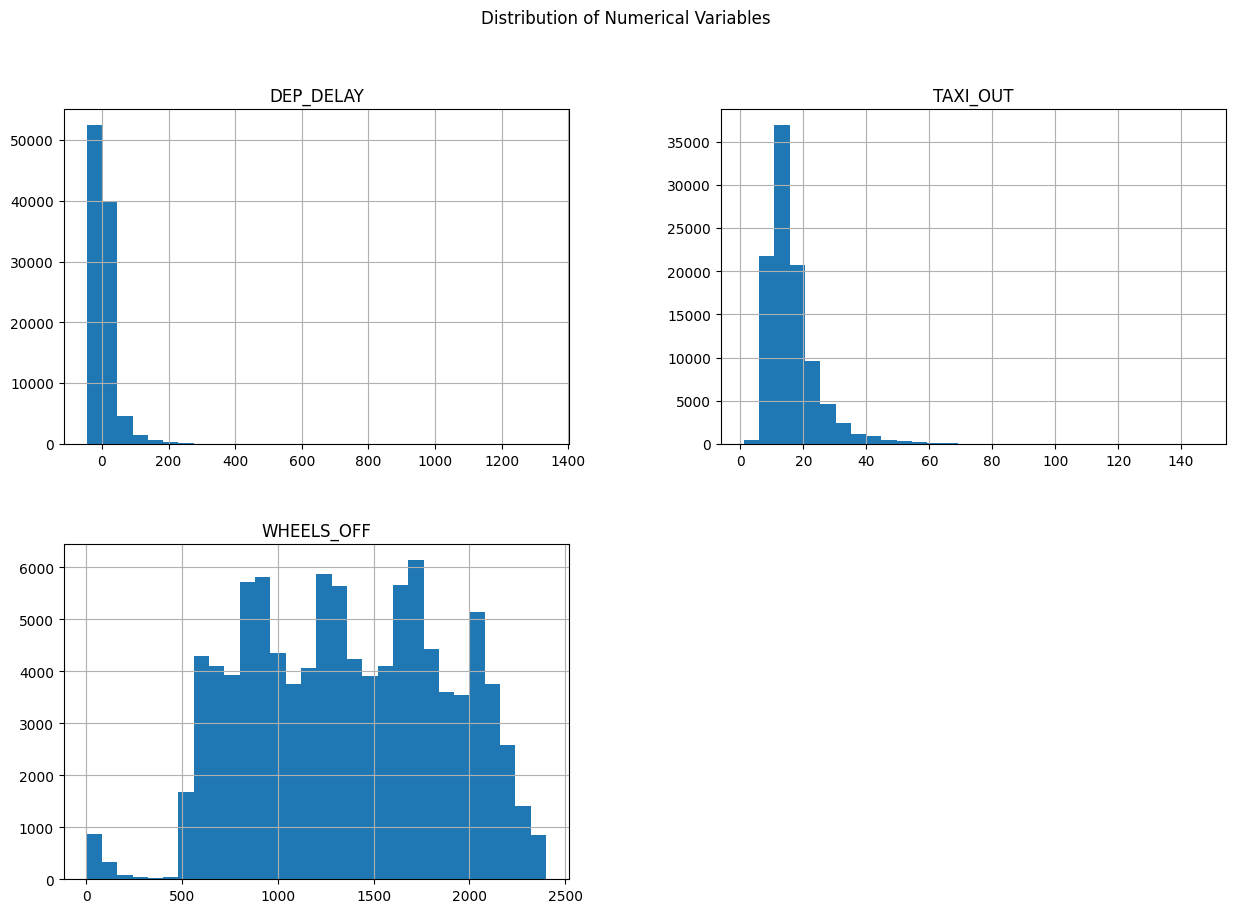

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for easier plotting
combined_df_pandas = cleaned_df_spark.select(['DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF']).limit(100000).toPandas()

# Plot histograms for numerical columns
combined_df_pandas.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

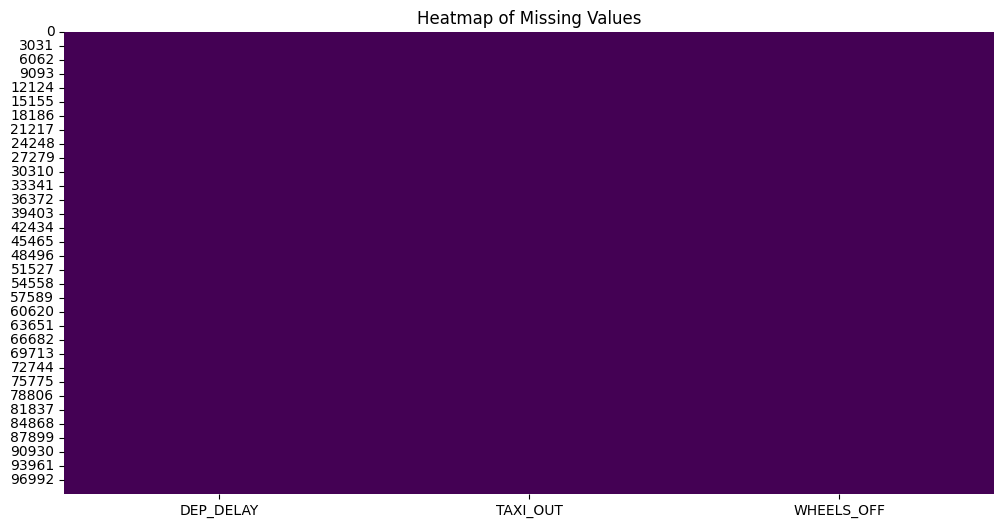

In [ ]:
# Heatmap to visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(combined_df_pandas.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

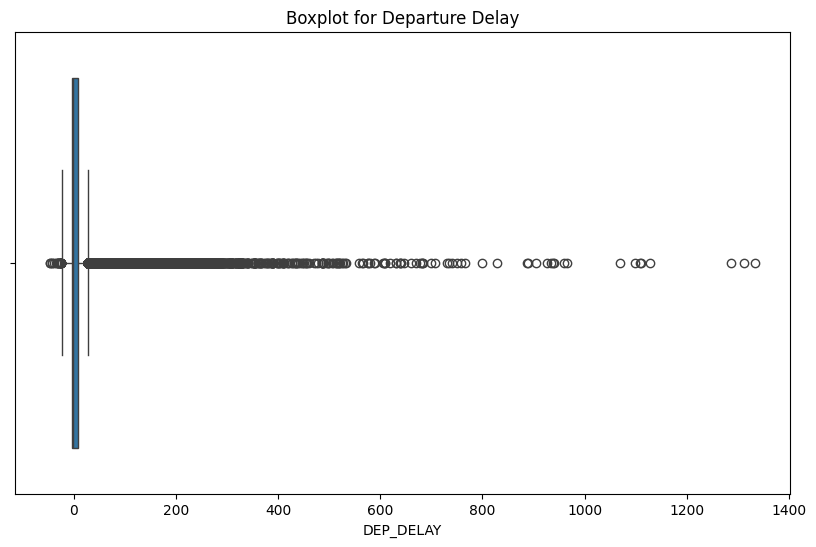

In [ ]:
# Boxplot for departure delay
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_df_pandas['DEP_DELAY'])
plt.title('Boxplot for Departure Delay')
plt.show()

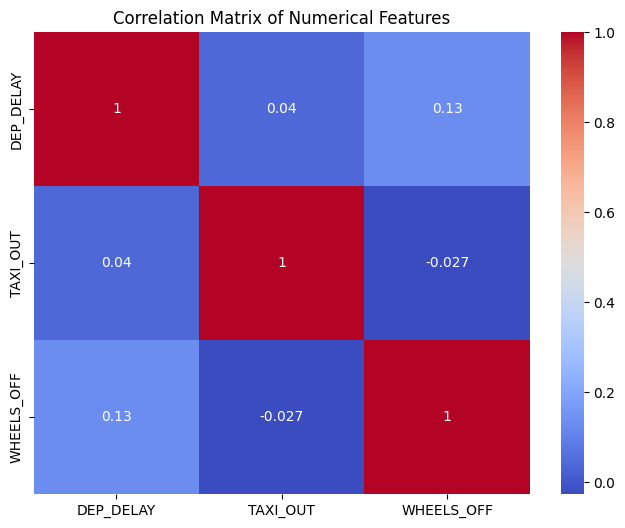

In [ ]:
# Correlation heatmap for numerical variables
plt.figure(figsize=(8, 6))
sns.heatmap(combined_df_pandas.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


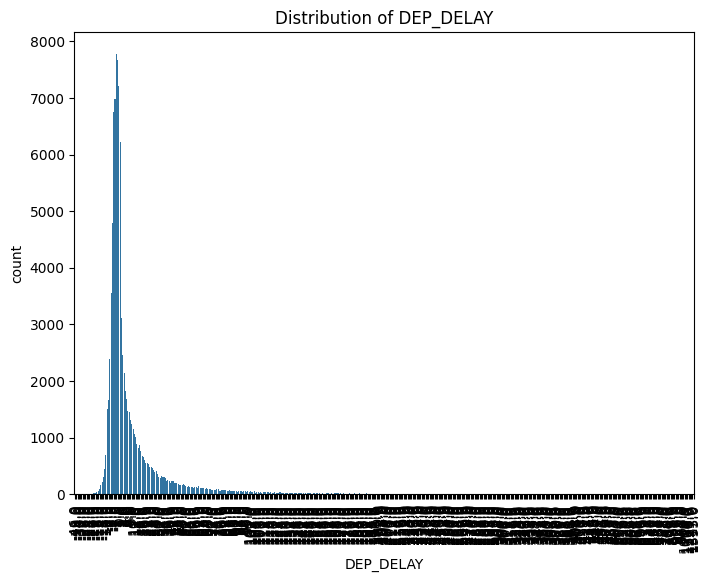

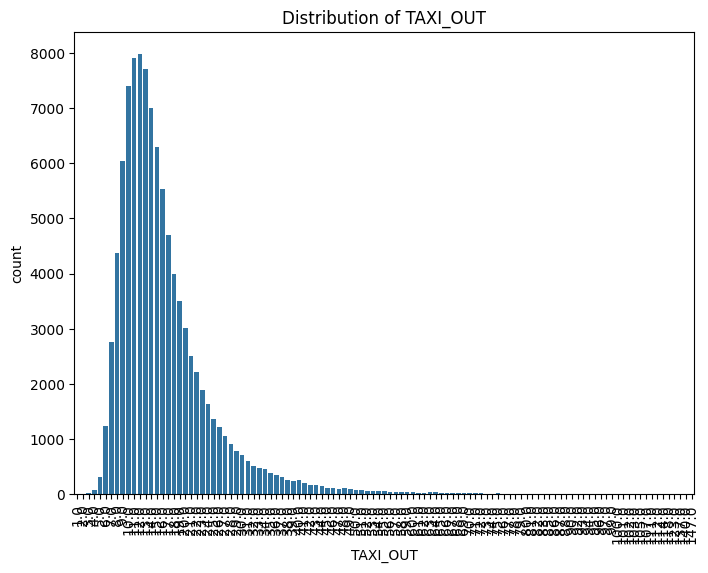

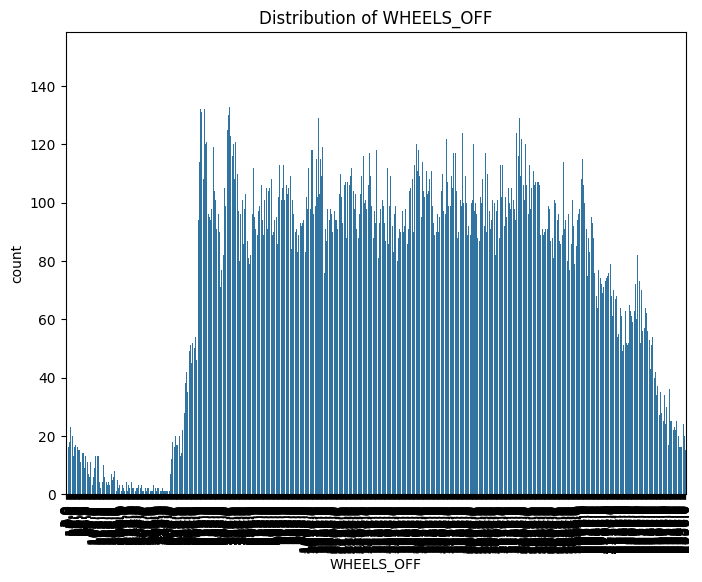

In [ ]:
# Count plots for categorical variables (e.g., 'Airline' or 'CancellationCode')
# Count plots for categorical variables (e.g., 'Airline' or 'CancellationCode')
for col in ['DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF']: # Changed the columns to ones that exist in the dataframe
    plt.figure(figsize=(8, 6))
    sns.countplot(data=combined_df_pandas, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

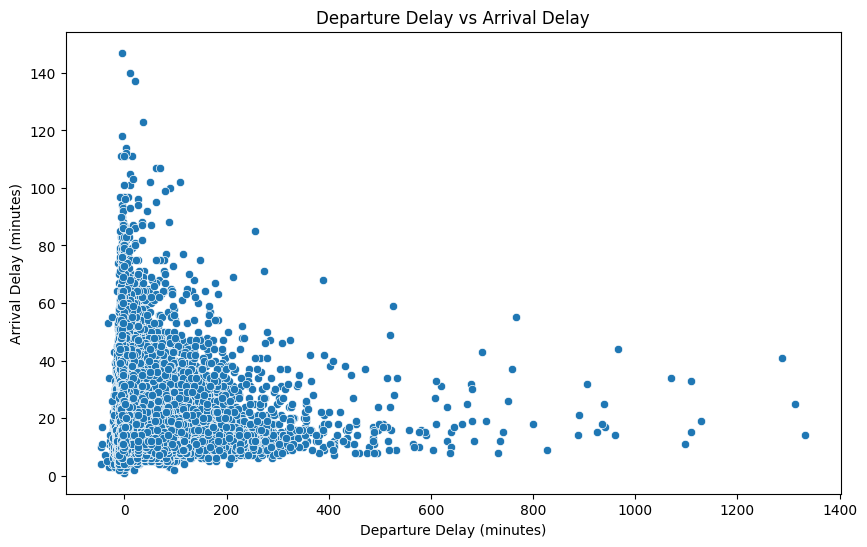

In [ ]:
# Scatter plot for departure delay vs arrival delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DEP_DELAY', y='TAXI_OUT', data=combined_df_pandas) # Changed column names to ones that exist
plt.title('Departure Delay vs Arrival Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

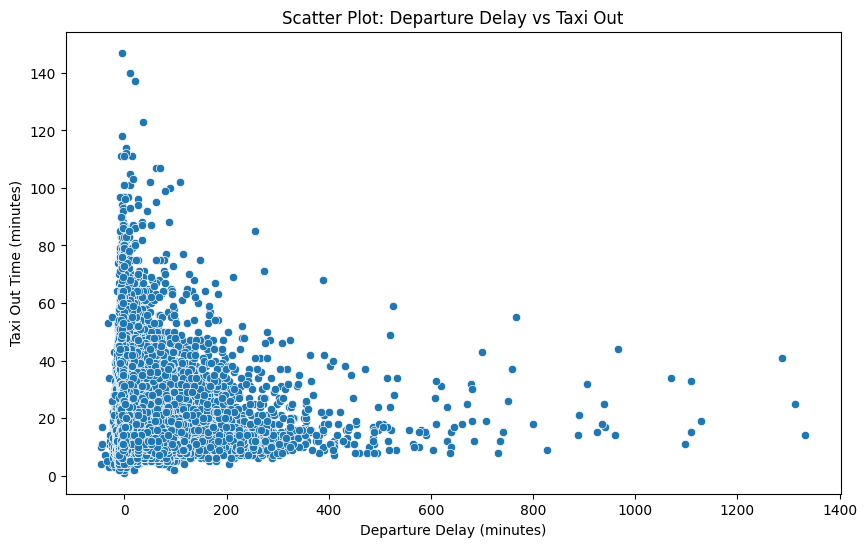

In [ ]:
# Scatter plot for Departure Delay vs Taxi Out time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DEP_DELAY', y='TAXI_OUT', data=combined_df_pandas)
plt.title('Scatter Plot: Departure Delay vs Taxi Out')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Taxi Out Time (minutes)')
plt.show()

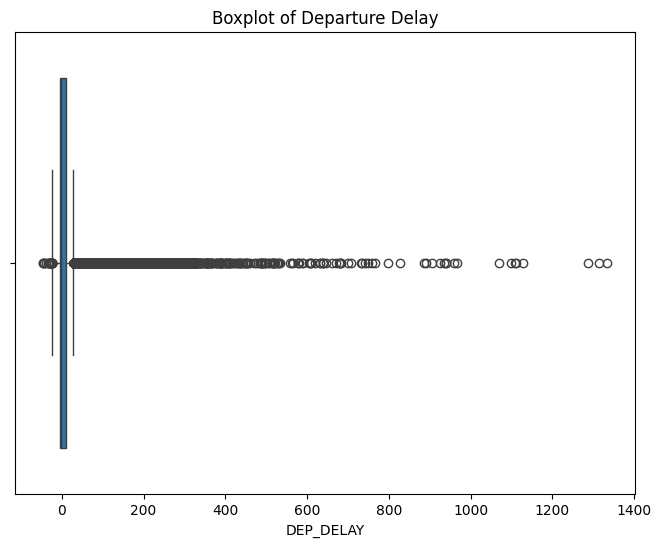

In [ ]:
# Boxplot for visualizing outliers in delays
plt.figure(figsize=(8, 6))
sns.boxplot(x='DEP_DELAY', data=combined_df_pandas) # Changed 'DepDelay' to 'DEP_DELAY'
plt.title('Boxplot of Departure Delay')
plt.show()

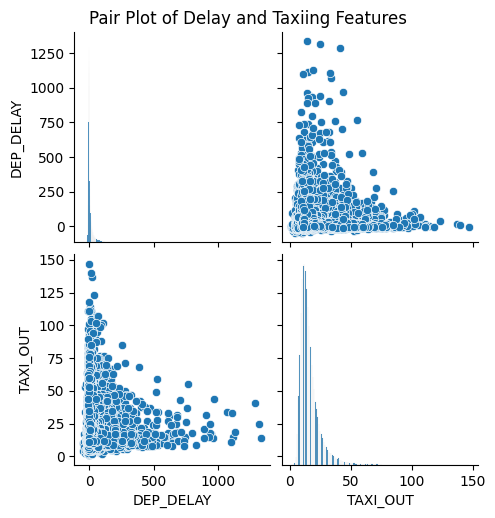

In [ ]:
# Pair plot to visualize relationships between features
sns.pairplot(combined_df_pandas[['DEP_DELAY', 'TAXI_OUT']]) # Removed the columns that don't exist in the DataFrame
plt.suptitle('Pair Plot of Delay and Taxiing Features', y=1.02)
plt.show()

# **MODEl Building**

In [ ]:
# Handling categorical features (e.g., OP_CARRIER)
indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_index")

In [ ]:
assembler = VectorAssembler(
    inputCols=['OP_CARRIER_index', 'CRS_DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF'],
    outputCol="features"
)

In [ ]:
# Preprocessing pipeline
pipeline = Pipeline(stages=[indexer, assembler])

In [ ]:
# Apply transformations
prepared_df = pipeline.fit(cleaned_df_spark).transform(cleaned_df_spark)

# Split the data into training and testing sets
train_data, test_data = prepared_df.randomSplit([0.8, 0.2], seed=42)

# **Regression Model**

In [25]:
lr = LinearRegression(labelCol="DEP_DELAY", featuresCol="features")

# Train the model
lr_model = lr.fit(train_data)
test_results = lr_model.transform(test_data)
test_results.select("DEP_DELAY", "prediction").show()

+---------+------------------+
|DEP_DELAY|        prediction|
+---------+------------------+
|     -5.0| 7.750429527152463|
|      1.0| 6.727456003277016|
|     -2.0|18.950112830139417|
|     -5.0| 8.562224729903967|
|     -4.0| 19.11941002826518|
|     -2.0|  3.49911780762611|
|      3.0|11.616162581991286|
|     -2.0| 9.765898552387156|
|    107.0|19.730829696720235|
|    246.0|11.900317497882252|
|     -5.0| 10.02503369889477|
|     -4.0| 8.837065973146018|
|     16.0| 6.380970172663295|
|     -3.0| 6.222684054447273|
|      4.0|13.892281461061678|
|      6.0| 16.16099921125392|
|     -3.0|18.150542389977115|
|     -3.0|17.363829858708044|
|     -8.0|  5.89018687350308|
|     -5.0|11.232347804384084|
+---------+------------------+
only showing top 20 rows



In [26]:
evaluator = RegressionEvaluator(labelCol="DEP_DELAY", predictionCol="prediction", metricName="rmse")

# Calculate RMSE
rmse = evaluator.evaluate(test_results)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 42.6957261430232


Random Forest Regression

In [27]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="DEP_DELAY", featuresCol="features")
rf_model = rf.fit(train_data)
test_results = rf_model.transform(test_data)

In [28]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_df = scaler.fit(prepared_df).transform(prepared_df)

# Use scaled features for modeling
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [32]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler

In [38]:
if 'OP_CARRIER_index' not in prepared_df.columns:
    carrier_indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_index")
    prepared_df = carrier_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("'OP_CARRIER_index' already exists. Skipping StringIndexer.")

'OP_CARRIER_index' already exists. Skipping StringIndexer.


In [40]:
assembler = VectorAssembler(
    inputCols=['OP_CARRIER_index', 'CRS_DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'DISTANCE', 'CRS_ARR_TIME'],
    outputCol="features"
)

# If 'features' column exists, drop it before transforming
if 'features' in prepared_df.columns:
    prepared_df = prepared_df.drop('features')

# Assemble features into the 'features' column
assembled_df = assembler.transform(prepared_df)

In [41]:
rf = RandomForestRegressor(labelCol="DEP_DELAY", featuresCol="scaled_features")

# Step 6: Train the RandomForest Model
rf_model = rf.fit(train_data)

In [42]:
test_results = rf_model.transform(test_data)

# Step 8: Evaluate the Model using RMSE
evaluator = RegressionEvaluator(labelCol="DEP_DELAY", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(test_results)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 9: Show Sample Predictions (Actual vs Predicted)
test_results.select("DEP_DELAY", "prediction").show(20)

Root Mean Squared Error (RMSE): 29.7149066082435
+---------+------------------+
|DEP_DELAY|        prediction|
+---------+------------------+
|     -5.0| 4.862127348797598|
|      1.0|2.7933636830864543|
|     -2.0|13.482310784023536|
|     -5.0| 4.678164223812877|
|     -4.0|13.918677240124799|
|     -2.0|0.6241488813807812|
|      3.0| 8.871183172274083|
|     -2.0|   6.8552168609644|
|    107.0| 20.81658021992305|
|    246.0|104.72646429989155|
|     -5.0| 6.206628516104127|
|     -4.0| 5.541540177771962|
|     16.0| 3.494042241401755|
|     -3.0| 3.411547882113028|
|      4.0|10.316829241232616|
|      6.0|13.918677240124799|
|     -3.0|13.679512296311179|
|     -3.0|16.013440732972143|
|     -8.0| 2.966682166401452|
|     -5.0| 8.629885762844454|
+---------+------------------+
only showing top 20 rows



# **Classification**

In [43]:
from pyspark.sql.functions import when

classified_df = cleaned_df_spark.withColumn("Delayed", when(cleaned_df_spark["DEP_DELAY"] > 15, 1).otherwise(0))

In [44]:
prepared_df = pipeline.fit(classified_df).transform(classified_df)

# Split into training and testing sets
train_data, test_data = prepared_df.randomSplit([0.8, 0.2], seed=42)

In [45]:
from pyspark.ml.classification import LogisticRegression

# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="Delayed", featuresCol="features")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
test_results = lr_model.transform(test_data)

# Display predictions
test_results.select("Delayed", "prediction").show()

+-------+----------+
|Delayed|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       1.0|
|      1|       1.0|
|      0|       0.0|
|      0|       0.0|
|      1|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 20 rows



In [46]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
accuracy = evaluator.evaluate(test_results)
print(f"Accuracy: {accuracy}")

Accuracy: 0.849492412855869
